## CS484 Final Project: Image inpainting using Object removal

Hello all
This is the showcase of our project

#### Section 1: Data gathering and cleaning
downloading the data and storing it on local file made easy. might create a seprate python file to streamline the process on the notebook ?

In [13]:
! pip install "deeplake<4.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 12.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.9 MB/s eta 0:0

In [85]:
import torch
from torch.utils.data import DataLoader
import torchvision.io as tvio
import torchvision.transforms as tfs
import torchvision.transforms.functional as tF

from download_dataset import DatasetDownloader
import numpy as np
import matplotlib.pyplot as plt

from utility_functions import RectanglePatch, CrossPatch, RandomHFlip, RandomVFlip, PairColorJitter, RandomResizeCrop, PairToTensors, PairNormalize, MakePair
from PIL import Image
from torch.utils.data import Dataset

from utility_functions import thinXMask, thickXMask, showResults
from basic_methods import nearestNeighbors, gaussianInpaint


In [86]:
#ds = DatasetDownloader.get_places()
#ds.visualize()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Section 2: Simple mathematical inpainting

Two simple ways to do inpainting is using gaussian blur, and nearest neighbors

Similar to clone stamp on photoshop


#### Set up images and masks

In [87]:
abbey = np.mean(np.load('images/abbey0.jpg.npy'), axis=2)

thinMask = thinXMask(abbey)
thickMask = thickXMask(abbey)

abbeyDamaged = abbey.copy()
abbeyDamaged[thinMask == 1] = 255

abbeyDamaged2 = abbey.copy()
abbeyDamaged2[thickMask == 1] = 255


#### Nearest Neighbors

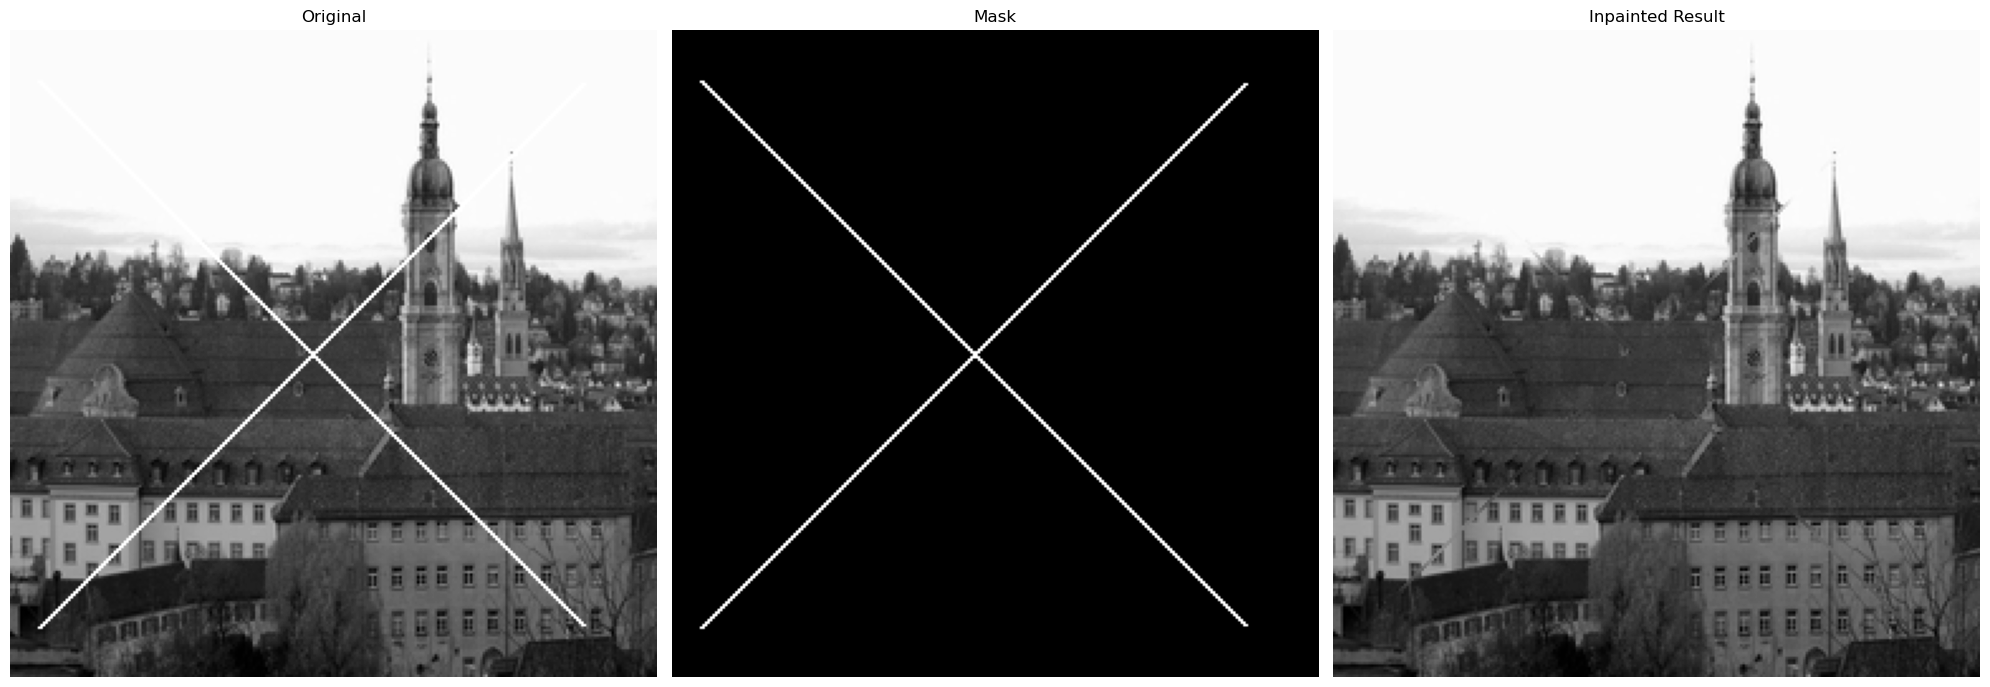

In [88]:

inpainted_image = nearestNeighbors(abbeyDamaged, thinMask)
showResults(abbeyDamaged, thinMask, inpainted_image)

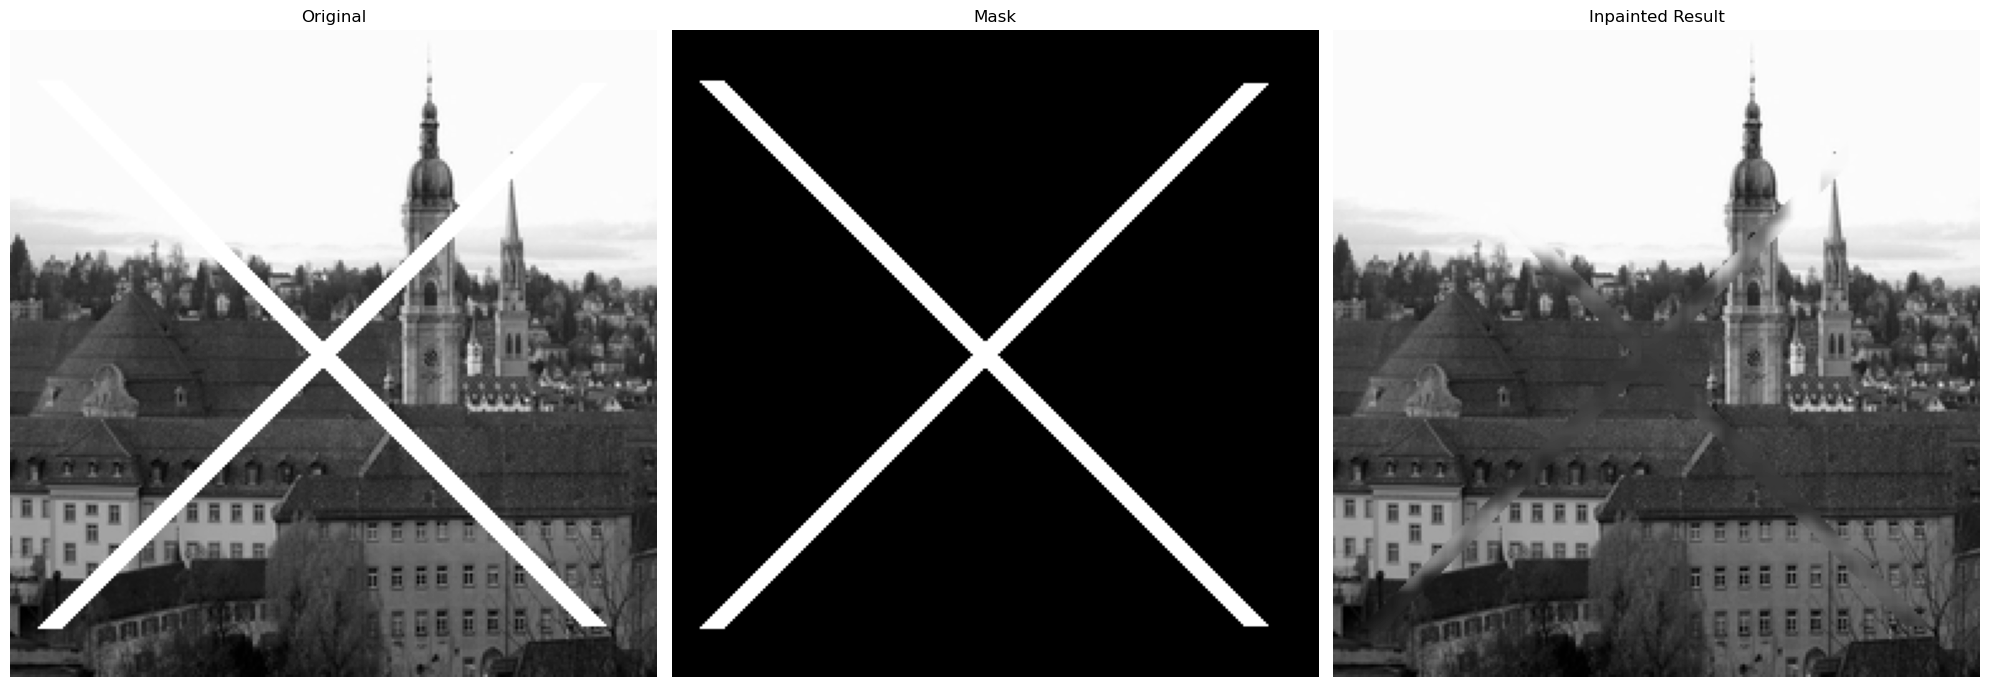

In [89]:
inpainted_image = nearestNeighbors(abbeyDamaged2, thickMask)
showResults(abbeyDamaged2, thickMask, inpainted_image)

#### Gaussian Blur

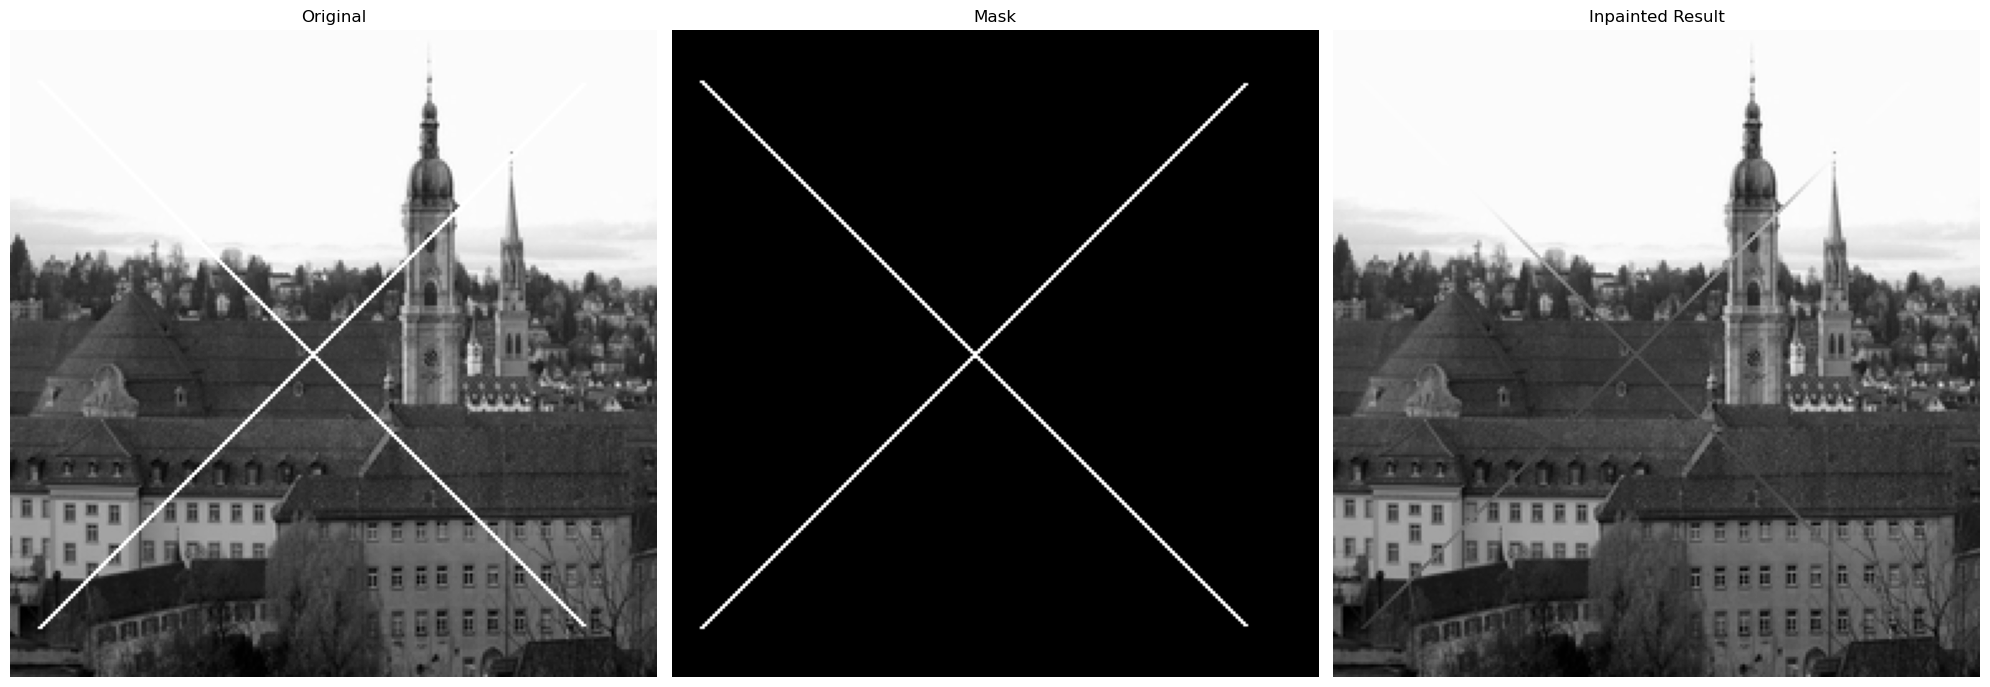

In [90]:
res = gaussianInpaint(abbeyDamaged, thinMask)
showResults(abbeyDamaged, thinMask, res)


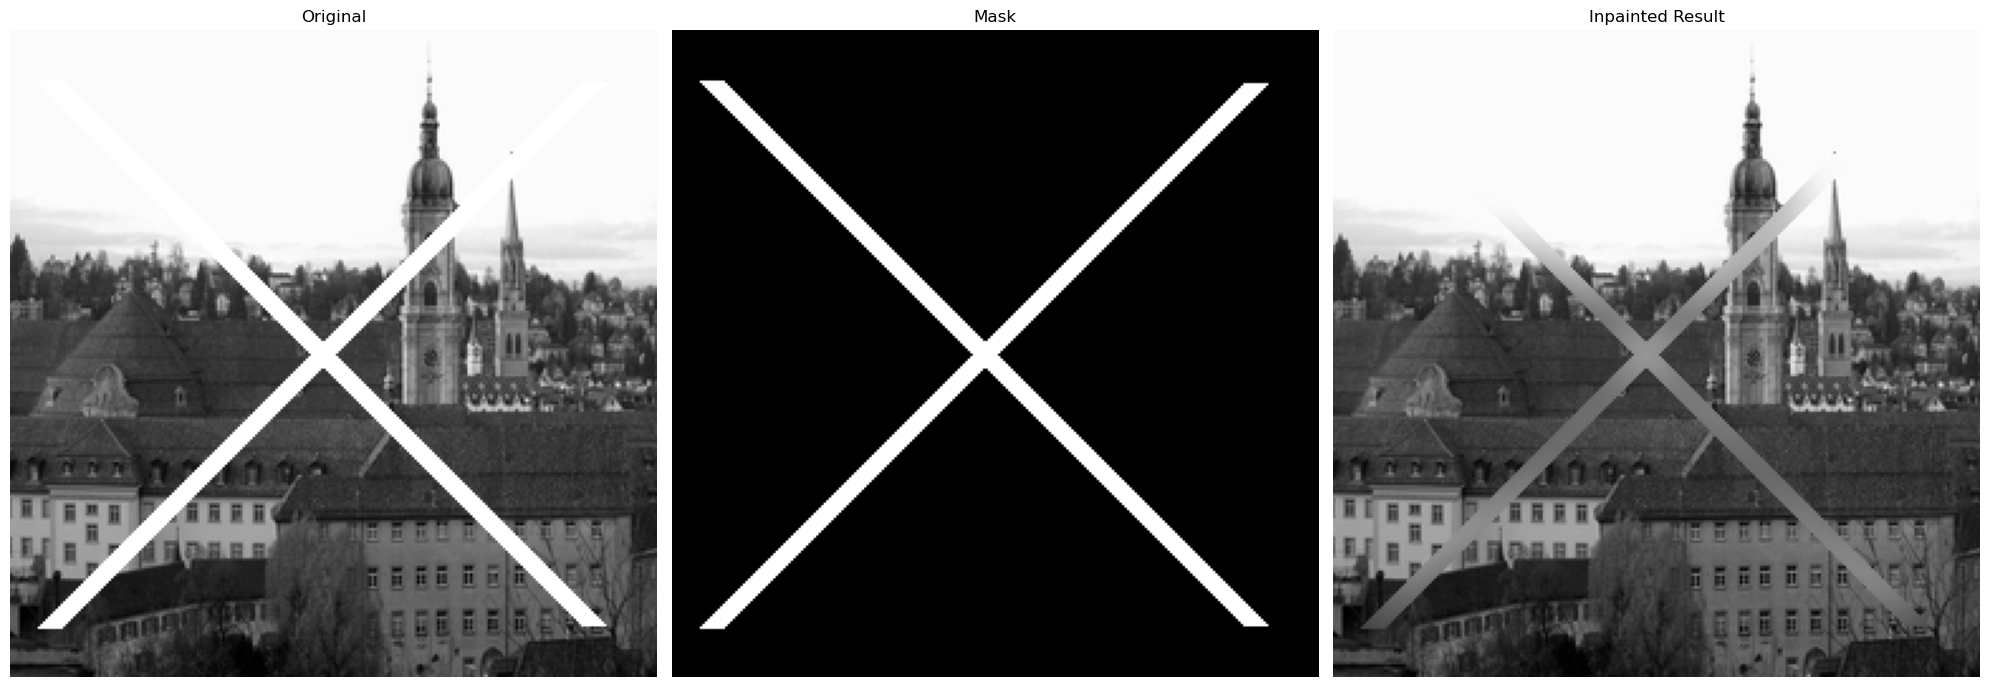

In [91]:
res = gaussianInpaint(abbeyDamaged2, thickMask)
showResults(abbeyDamaged2, thickMask, res)

#### Section 3: Object detection and removal
for this section we will be using either two methods for patch selection:
- simple rectangle patch
- Object selection using deep segmentaiton methods with the help  of labels like in A5 ? (optional)

The goal of this section is to create the dataset that is ready to be used for training/validating. for each image in the data set we should have an (Image - patch, Image) in the final dataset, ready to be trained (or in the least, the region to be removed is somehow indicated?)

In [300]:

class RectanglePatch_Location(object):
  def __init__(self, patch_size, patch_loc):
      self.patch_size = patch_size
      self.patch_loc = patch_loc

  def __call__(self, pair):

    img, target = pair

    #orig = img.copy()
    new_img = np.array(img)

    imgW, imgH, _ = new_img.shape
    patchW, patchH = self.patch_size
    x, y = self.patch_loc
    new_img[x: x + patchW, y: y + patchH] = 255

    res = Image.fromarray(new_img) 

    return (res, target)

def get_rectangle_mask(img, patch_loc, patch_size): # get into util func.py
    retval = np.full_like(img, fill_value=255)
    x, y = patch_loc
    sx, sy = patch_size
    retval[x: x+sx, y:y+sy, :] = 0 
    return retval
PATCH_SIZE = (20, 20)
PATCH_LOC = (128, 128)

In [270]:
ds = DatasetDownloader.get_places()
image_set = ds.images[0:2000].numpy(aslist=True)
rgb_set = list(filter(lambda x: x.shape[2] == 3,image_set)) #filtering out
print(len(rgb_set))

|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/places205



\

hub://activeloop/places205 loaded successfully.



1901


In [99]:
import random
random.seed(2024)
shuffled = rgb_set[:]
random.shuffle(shuffled)
l = len(rgb_set)
l_train = int(l * 0.8)

train_set = shuffled[0:l_train]
val_set = shuffled[l_train:]

In [301]:

training_data, validation_data = shuffled[0:l_train], shuffled[l_train:]

class CustomPlaces(Dataset):
    def __init__(self, data: list[np.ndarray], transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        withPatch, target = self.transform(img)
        return withPatch, target

class CustomPlaces_Masked(Dataset):
    def __init__(self, data: list[np.ndarray], transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        # withPatch, _ = self.transform(img)
        mask = get_rectangle_mask(img, PATCH_LOC, PATCH_SIZE)
        return PairToTensors()((img, mask))


training_img_transform = tfs.Compose([
  MakePair(),
  RandomHFlip(),
  RandomVFlip(),
  # PairColorJitter(),
  RandomResizeCrop(size=256, min_scale=0.7, max_scale=1.3),
  RectanglePatch_Location(patch_size=PATCH_SIZE, patch_loc=PATCH_LOC),
  PairToTensors()
  # PairNormalize(mean = ???, std = ???)
  ])

validation_img_transform = tfs.Compose([
    MakePair(),
    RectanglePatch_Location(patch_size=PATCH_SIZE, patch_loc=PATCH_LOC),
    PairToTensors(),
   # PairNormalize( mean = ???, std = ???)
])

training_cross_transform = tfs.Compose([
  MakePair(),
  RandomHFlip(),
  RandomVFlip(),
  PairColorJitter(),
  RandomResizeCrop(size=256, min_scale=0.7, max_scale=1.3),
  CrossPatch(patch_size=5),
  # PairToTensors()
])

training_ds = CustomPlaces(data = training_data, transform=training_img_transform)
validating_ds = CustomPlaces(data = validation_data, transform=validation_img_transform)
sample_ds = CustomPlaces(data = [training_data[0]], transform=validation_img_transform)

training_cross_ds = CustomPlaces(data = training_data, transform=training_cross_transform)
validating_cross_ds = CustomPlaces(data = validation_data, transform=validation_img_transform)

1520


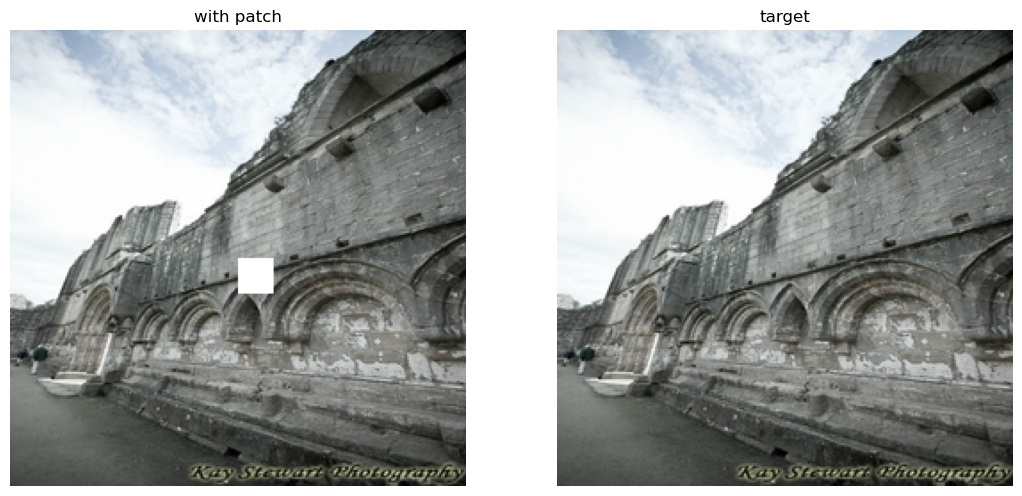

In [302]:
#feel free to delete\

def torch_image_to_numpy(img): # get into utility func.py
    return img.permute(1, 2, 0).cpu().detach().numpy() 

x = sample_ds[0]

plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.imshow(torch_image_to_numpy(x[0]), vmin=0, vmax=255)
plt.title('with patch')
plt.axis('off')

plt.subplot(132)
plt.imshow(torch_image_to_numpy(x[1]), vmin=0, vmax=255)
plt.title('target')
plt.axis('off')
print(len(training_ds))

In [303]:
# these are just copied from A5
TRAIN_BATCH_SIZE = 40 # too low !
NUM_WORKERS = 0

train_loader = DataLoader(training_ds, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(validating_ds, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
sample_loader = DataLoader(sample_ds, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

In [304]:
train_cross_loader = DataLoader(training_ds, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val__cross_loader = DataLoader(validating_ds, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

(-0.5, 255.5, 255.5, -0.5)

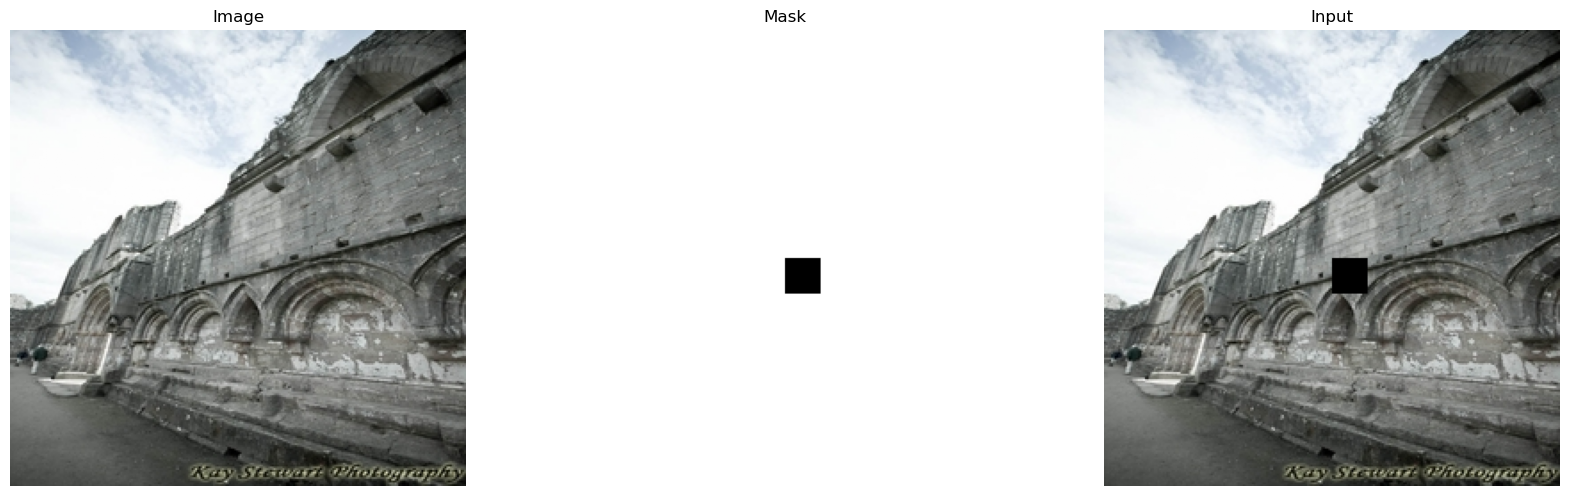

In [320]:
sample_ds = CustomPlaces_Masked(data = [training_data[0]])
sample_loader_masked = DataLoader(sample_ds, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)
x = sample_ds[0]

plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.imshow(torch_image_to_numpy(x[0]), vmin=0, vmax=255)
plt.title('Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(torch_image_to_numpy(x[1]), vmin=0, vmax=255)
plt.title('Mask')
plt.axis('off')

plt.subplot(133)
plt.imshow(torch_image_to_numpy(x[0] * x[1]), vmin=0, vmax=255)
plt.title('Input')
plt.axis('off')



#### Section 4: Creating the  model for the network
the first simple approach would be to use an autoencoder and self-supervision to fit the model to the dataset.

questions:
- how good would the image quality be?
- what if we change the location of the patch?
- how would loss functions affect the quality of the output?
- what if patch was not rectangular?
- how to avoid overfitting?

In [121]:
import torch.nn as nn

class InpaintingAutoencoder(nn.Module):
    def __init__(self, input_shape: tuple[int, int], patch_size: tuple[int, int], patch_loc: tuple[int, int]):
        super().__init__()
        c, h,w = input_shape
        self.patch_size = patch_size
        self.patch_loc = patch_loc
        
        self.encoder = nn.Sequential(

            nn.Conv2d(c, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=c, kernel_size=3, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        px, py = self.patch_loc
        sx, sy = self.patch_size
        img = x.clone()
        img[:, :, px:px+sx, py:py + sy] = decoded
        return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


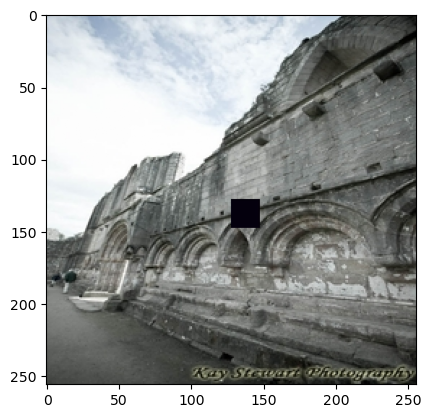

In [123]:
net = InpaintingAutoencoder(input_shape=(3, 256, 256), patch_size=(20, 20), patch_loc=(128, 128))
data_iter = iter(sample_loader)
data = next(data_iter)

image, target = data
output = net.forward(image)
output = torch_image_to_numpy(output[0])

plt.imshow(output)


In [124]:
from torch.optim.optimizer import Optimizer
from torch.optim import Adam
from tqdm import tqdm
def train_AE(ae_net: nn.Module, loader: DataLoader, optim: Optimizer, loss_func: nn.Module):
    
    loss_values = []
    ae_net.to(device)
    loss_func.to(device)
    for data in loader:
        input, target = data

        input = input.to(device)
        target = target.to(device)
        
        optim.zero_grad()
        output = ae_net.forward(input)
        loss = loss_func(output, target)
        loss.backward()
        optim.step()
        
        loss_values.append(loss.item())
    
    return loss_values

loss_functions = nn.MSELoss()
def getOptim(net: nn.Module, lr: float):
    return Adam(net.parameters(), lr)

100%|██████████| 20/20 [00:00<00:00, 44.39it/s]


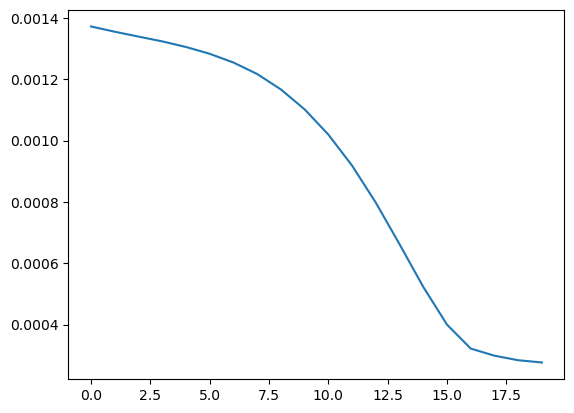

In [125]:
overfit_net = InpaintingAutoencoder(input_shape=(3, 256, 256), patch_size=(20, 20), patch_loc=(128, 128))
epoch = 20
loss_values = []
for e in tqdm(range(epoch)):
    losses = train_AE(overfit_net, sample_loader, getOptim(overfit_net, 0.0001), loss_functions)
    loss_values += losses

plt.plot(loss_values)


(256, 256, 3)


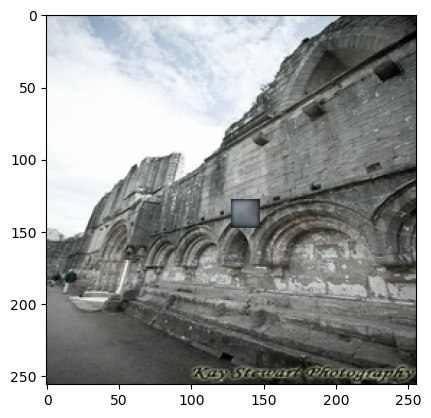

In [126]:
output = overfit_net.forward(image.to(device))
output = torch_image_to_numpy(output[0])
print(output.shape)

plt.imshow(output)

#### Section 3.1: Training the model, displaying the results

In [127]:
trained_net = InpaintingAutoencoder(input_shape=(3, 256, 256), patch_size=PATCH_SIZE, patch_loc=PATCH_LOC)
epoch = 5
loss_values = []
for e in tqdm(range(epoch)):
    losses = train_AE(trained_net, train_loader, getOptim(trained_net, 0.0001), loss_functions)
    loss_values += losses

100%|██████████| 5/5 [00:55<00:00, 11.19s/it]


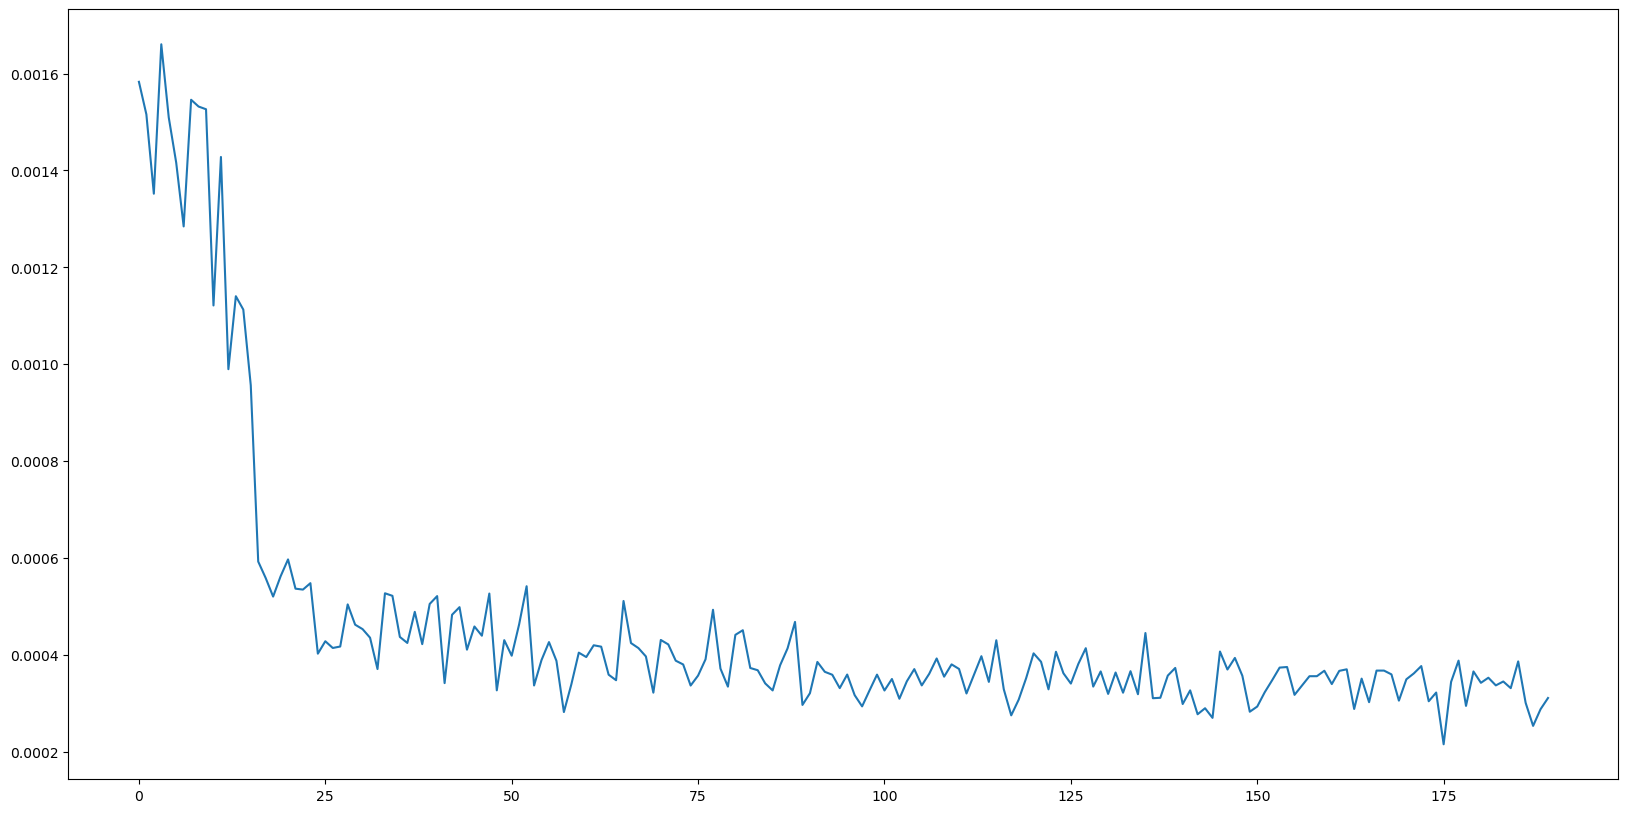

In [128]:
plt.figure(figsize=(20, 10))
plt.plot(loss_values)

(256, 256, 3)


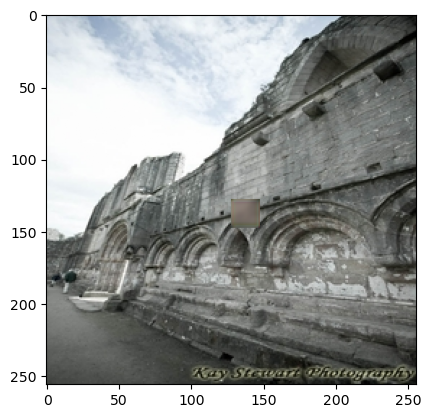

In [129]:
output = trained_net.forward(image.to(device))
output = torch_image_to_numpy(output[0])
print(output.shape)

plt.imshow(output)

(-0.5, 255.5, 255.5, -0.5)

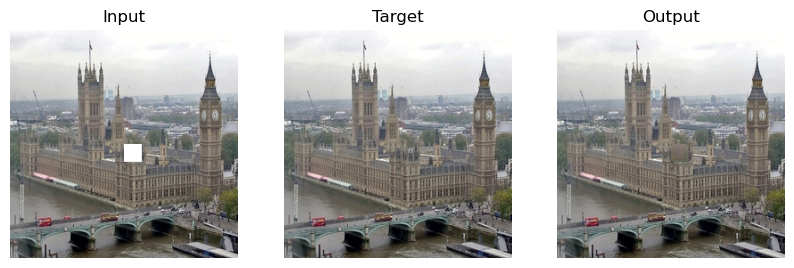

In [134]:
img2 = val_set[0] # will be used for sanity testing the model

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns
results, target = RectanglePatch_Location((20, 20), (128, 128),)(MakePair()(img2))

axes[0].imshow(results)
axes[0].set_title("Input")
axes[0].axis('off')

axes[1].imshow(target)
axes[1].set_title("Target")
axes[1].axis('off')

ds_test = CustomPlaces([img2], transform=validation_img_transform)
dl_test = DataLoader(ds_test, shuffle=False)
data_iter = iter(dl_test)
data = next(data_iter)
image, target = data
output = trained_net.forward(image.to(device))
output = torch_image_to_numpy(output[0])

axes[2].imshow(output)
axes[2].set_title("Output")
axes[2].axis('off')

#### Section 4.2: Unet architecture, a better solution?
Unet architectures are used in many instances for image inpainting, because of their very natures of "holding attention" using their skip connections



In [397]:
"""
    a Partial convolution layer: given an image and a mask, only apply convlution results to the mask!
"""
class PartialConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernal_size, stride=1, padding=0, bias=True):
        super(PartialConv2d, self).__init__(in_channels, out_channels, kernal_size, stride=stride, padding=padding, bias=bias)
        self.mask_kernel = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        self.update_mask = None
        self.mask_ratio = None
        torch.nn.init.xavier_uniform_(self.weight)
    
    def forward(self, img, mask):
        with torch.no_grad():
            self.mask_kernel.to(device)
            if self.mask_kernel.type() != img.type():
                self.mask_kernel = self.mask_kernel.to(img)
            self.update_mask = nn.functional.conv2d(mask, self.mask_kernel
                                                    ,stride=self.stride, padding=self.padding)
            total_sum = self.mask_kernel.shape[1] * self.mask_kernel.shape[2] * self.mask_kernel.shape[3]
            self.mask_ratio = total_sum / (self.update_mask + 1e-8)
            self.update_mask = torch.clamp(self.update_mask, 0, 1)
            self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)
        
        input = torch.mul(img, mask)
        conv_res = nn.functional.conv2d(input, self.weight, self.bias, self.stride, self.padding)

        if self.bias is not None:
            # Maltuply WT . (X * M) and sum(1) / sum(M) and Add the bias
            bias_view = self.bias.view(1, self.out_channels, 1, 1)
            output = torch.mul(conv_res - bias_view, self.mask_ratio) + bias_view
            # The masked part pixel is updated to 0
            output = torch.mul(output, self.mask_ratio)
        else:
            # Multiply WT . (X * M) and sum(1) / sum(M)
            output = torch.mul(conv_res, self.mask_ratio)

        return output, self.update_mask

class UpsampleConcat(nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, dec_feature, dec_mask, enc_feature, enc_mask):
        # upsample and concat features
        out = torch.cat([self.upsample(dec_feature), enc_feature], dim=1)
        # upsample and concat masks
        out_mask = torch.cat([self.upsample(dec_mask), enc_mask], dim=1)
        return out, out_mask


class Unet_encoder(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, batch_norm=False):
        super().__init__()
        self.conv_layer = PartialConv2d(input_ch, output_ch, kernel_size, stride, padding)
        self.active = nn.ReLU()
        self.bn = nn.BatchNorm2d(output_ch) if batch_norm else None
    
    def forward(self, x, mask):
        out, out_mask = self.conv_layer(x, mask)
        if (self.bn): # Is not None
            out = self.bn(out)
        out = self.active(out)
        return out, out_mask

class Unet_decoder(nn.Module):
    def __init__(self, input_ch, output_ch, batch_norm=False):
        super().__init__()
        self.conv_layer = PartialConv2d(input_ch, output_ch, 3, 1, 1)
        self.upsample = UpsampleConcat()
        self.active = nn.LeakyReLU(negative_slope=0.2)
        self.bn = nn.BatchNorm2d(output_ch) if batch_norm else None
    
    def forward(self, x, mask, skip_x, skip_mask):
        up, up_mask = self.upsample(x, mask, skip_x, skip_mask)
        out, out_mask = self.conv_layer(up, up_mask)
        if (self.bn): # Is not None
            out = self.bn(out)
        out = self.active(out)


        
        return out, out_mask


class Unet_Inpainter(nn.Module):
    def __init__(self, in_channel=3):
        super().__init__() 

        self.enc1 = Unet_encoder(in_channel, 64, kernel_size=7, stride=2, padding=3) 
        self.enc2 = Unet_encoder(64, 128, kernel_size=5, stride=2, padding=2, batch_norm=True)
        self.enc3 = Unet_encoder(128, 256, kernel_size=5, stride=2, padding=2, batch_norm=True)
        self.enc4 = Unet_encoder(256, 512, kernel_size=3, stride=2, padding=1, batch_norm=True)
        


        self.dec3 = Unet_decoder(768, 256, batch_norm=True)
        self.dec2 = Unet_decoder(384, 128, batch_norm=True)
        self.dec1 = Unet_decoder(192, 64, batch_norm=True)

        self.final_upsample = UpsampleConcat()
        self.output_layer = PartialConv2d(67, 3, 3, 1, 1, bias=False)
        
               
        
    
    def forward(self, x):
        img, mask = x
        encd1, encd_mask1 = self.enc1(*x)
        encd2, encd_mask2 = self.enc2(encd1, encd_mask1)
        encd3, encd_mask3 = self.enc3(encd2, encd_mask2)
        encd4, encd_mask4 = self.enc4(encd3, encd_mask3)

        decd3, decd_mask3 = self.dec3(encd4, encd_mask4, encd3, encd_mask3)
        decd2, decd_mask2 = self.dec2(decd3, decd_mask3, encd2, encd_mask2)
        decd1, decd_mask1 = self.dec1(decd2, decd_mask2, encd1, encd_mask1)


        
        final_up, final_up_mask = self.final_upsample(decd1, decd_mask1, img, mask)
        output, output_mask = self.output_layer(final_up, final_up_mask)
        return output, output_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


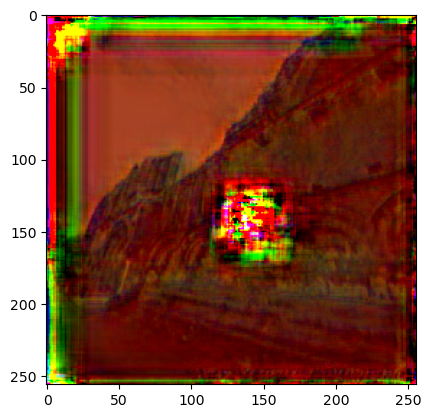

In [398]:
net = Unet_Inpainter()
data_iter = iter(sample_loader_masked)
data = next(data_iter)

image, mask = data
output, output_mask = net.forward((image, mask))
output = torch_image_to_numpy(output[0])

plt.imshow(output)

#### for the porpuse of training this model a custom loss function is needed

In [399]:
from torchvision import models
class InpaintingLoss(nn.Module):
    def __init__(self, extractor, tv_loss='mean'):
        super(InpaintingLoss, self).__init__()
        self.tv_loss = tv_loss
        self.l1 = nn.L1Loss()
        # default extractor is VGG16
        self.extractor = extractor

    def forward(self, input, mask, output, gt):
        # Non-hole pixels directly set to ground truth
        comp = mask * input + (1 - mask) * output

        # Total Variation Regularization
        tv_loss = total_variation_loss(comp, mask, self.tv_loss)
        # tv_loss = (torch.mean(torch.abs(comp[:, :, :, :-1] - comp[:, :, :, 1:])) \
        #           + torch.mean(torch.abs(comp[:, :, :, 1:] - comp[:, :, :, :-1])) \
        #           + torch.mean(torch.abs(comp[:, :, :-1, :] - comp[:, :, 1:, :])) \
        #           + torch.mean(torch.abs(comp[:, :, 1:, :] - comp[:, :, :-1, :]))) / 2

        # Hole Pixel Loss
        hole_loss = self.l1((1-mask) * output, (1-mask) * gt)

        # Valid Pixel Loss
        valid_loss = self.l1(mask * output, mask * gt)

        # Perceptual Loss and Style Loss
        feats_out = self.extractor(output)
        feats_comp = self.extractor(comp)
        feats_gt = self.extractor(gt)
        perc_loss = 0.0
        style_loss = 0.0
        # Calculate the L1Loss for each feature map
        for i in range(3):
            perc_loss += self.l1(feats_out[i], feats_gt[i])
            perc_loss += self.l1(feats_comp[i], feats_gt[i])
            style_loss += self.l1(gram_matrix(feats_out[i]),
                                  gram_matrix(feats_gt[i]))
            style_loss += self.l1(gram_matrix(feats_comp[i]),
                                  gram_matrix(feats_gt[i]))

        return {'valid': valid_loss,
                'hole': hole_loss,
                'perc': perc_loss,
                'style': style_loss,
                'tv': tv_loss}
# The network of extracting the feature for perceptual and style loss
class VGG16FeatureExtractor(nn.Module):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]

    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)
        normalization = Normalization(self.MEAN, self.STD)
        # Define the each feature exractor
        self.enc_1 = nn.Sequential(normalization, *vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        # fix the encoder
        for i in range(3):
            for param in getattr(self, 'enc_{}'.format(i+1)).parameters():
                param.requires_grad = False

    def forward(self, input):
        feature_maps = [input]
        for i in range(3):
            feature_map = getattr(self, 'enc_{}'.format(i+1))(feature_maps[-1])
            feature_maps.append(feature_map)
        return feature_maps[1:]


# Normalization Layer for VGG
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, input):
        # normalize img
        if self.mean.type() != input.type():
            self.mean = self.mean.to(input)
            self.std = self.std.to(input)
        return (input - self.mean) / self.std


# Calcurate the Gram Matrix of feature maps
def gram_matrix(feat):
    (b, ch, h, w) = feat.size()
    feat = feat.view(b, ch, h * w)
    feat_t = feat.transpose(1, 2)
    gram = torch.bmm(feat, feat_t) / (ch * h * w)
    return gram


def dialation_holes(hole_mask):
    b, ch, h, w = hole_mask.shape
    dilation_conv = nn.Conv2d(ch, ch, 3, padding=1, bias=False).to(hole_mask)
    torch.nn.init.constant_(dilation_conv.weight, 1.0)
    with torch.no_grad():
        output_mask = dilation_conv(hole_mask)
    updated_holes = output_mask != 0
    return updated_holes.float()


def total_variation_loss(image, mask, method):
    hole_mask = 1 - mask
    dilated_holes = dialation_holes(hole_mask)
    colomns_in_Pset = dilated_holes[:, :, :, 1:] * dilated_holes[:, :, :, :-1]
    rows_in_Pset = dilated_holes[:, :, 1:, :] * dilated_holes[:, :, :-1:, :]
    if method == 'sum':
        loss = torch.sum(torch.abs(colomns_in_Pset*(
                    image[:, :, :, 1:] - image[:, :, :, :-1]))) + \
            torch.sum(torch.abs(rows_in_Pset*(
                    image[:, :, :1, :] - image[:, :, -1:, :])))
    else:
        loss = torch.mean(torch.abs(colomns_in_Pset*(
                    image[:, :, :, 1:] - image[:, :, :, :-1]))) + \
            torch.mean(torch.abs(rows_in_Pset*(
                    image[:, :, :1, :] - image[:, :, -1:, :])))
    return loss


100%|██████████| 100/100 [00:04<00:00, 22.09it/s]


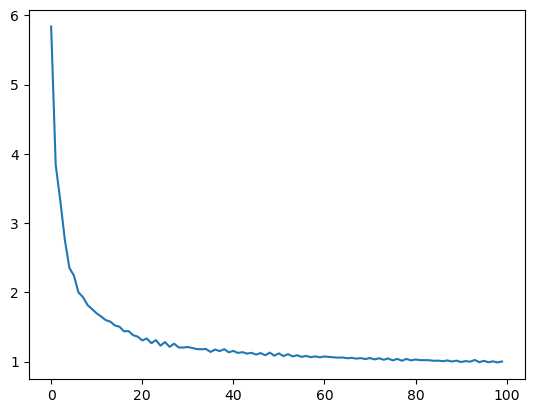

In [417]:
loss_functions = InpaintingLoss(VGG16FeatureExtractor()).to(device)
def getOptim(net: nn.Module, lr: float):
    return Adam(net.parameters(), lr)

def train_Unet(net: nn.Module, loader: DataLoader, optim: Optimizer, loss_func: nn.Module):
    
    loss_values = []
    net.to(device)
    loss_func.to(device)
    for data in loader:
        input, mask = data

        input = input.to(device)
        mask = mask.to(device)
        
        optim.zero_grad()
        output, output_mask = net.forward((input, mask))
        coefs = [1.0, 6.0, 0.1, 0.05, 120.0]
        loss_dict = loss_func(input, mask, output, input)
        loss_val = 0.0
        for i, pair in enumerate(loss_dict.items()):
            loss_val += pair[1] * coefs[i]
        
        loss_val.backward()
        optim.step()
        
        loss_values.append(loss_val.item())
    
    return loss_values

overfit_net = Unet_Inpainter()
epoch = 100
loss_values = []
for e in tqdm(range(epoch)):
    losses = train_Unet(overfit_net, sample_loader_masked, getOptim(overfit_net, 0.0003), loss_functions)
    loss_values += losses

plt.plot(loss_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


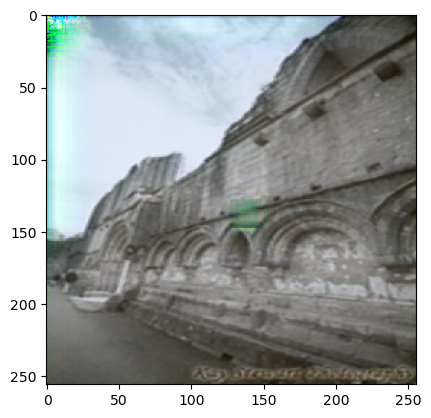

In [418]:
data_iter = iter(sample_loader_masked)
data = next(data_iter)

image, mask = data

output, output_mask = overfit_net.forward((image.to(device), mask.to(device)))
output = torch_image_to_numpy(output[0])

plt.imshow(output)

#### Section 5: GANS, creating competition for the network using a "detector"

#### Section 5.1: Training the model, displaying the results

#### Section 6(if we had time): using image segmentation from assignment 4 part 2, to remove objects from image and using network from before to fill in the "patch"